In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import sys
sys.path.append("./..")
sys.path.append(".")

In [144]:
from pathlib import Path
import pprint
import hashlib

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from dotted_dict import DottedDict
#
from effcn.layers import View, Squash
from effcn.functions import margin_loss

In [43]:
ds_train = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
ds_valid = datasets.MNIST(root="./data", train=False, download=True, transform=T.ToTensor())

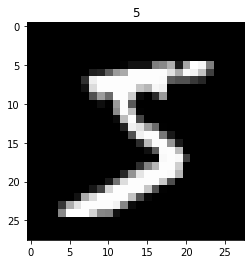

In [44]:
plt.imshow(ds_train.data[0], cmap='gray')
plt.title('%i' % ds_train.targets[0])
plt.show()

In [178]:
dl_train = torch.utils.data.DataLoader(ds_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=4)

In [179]:
class CNN_CR_SF(nn.Module):
    def __init__(self):
        super(CNN_CR_SF, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=256,            
                kernel_size=9,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(256, 256, 9, 2),     
            nn.ReLU(),                                 
        )
        self.fc1 = nn.Linear(256 * 6 * 6, 16 * 8)
        self.sq = Squash(eps=1e-20)
        self.fc2 =  nn.Linear(16 * 8, 16 * 10)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = x.view(-1,16,8)
        x = self.sq(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc2(x)
        x = x.view(-1,10,16)
        x = self.sq(x)
        return x

In [180]:
model = CNN_CR_SF()
img, y = next(iter(dl_train))
#img = ds_train[0][0]
#img = torch.unsqueeze(img,dim=0)
#y = ds_train[0][1]

x = model(img)
#model.fc1(x)

print(img.shape)
print(x.shape)
print(y)
y_one_hot = F.one_hot(y, num_classes=10)

y_one_hot.shape

print(margin_loss(x, y_one_hot))




#x_norm = torch.norm(x, dim=2)
#print(x_norm.shape)
#print(x_norm)



torch.Size([256, 1, 28, 28])
torch.Size([256, 10, 16])
tensor([0, 1, 6, 6, 4, 0, 3, 1, 5, 1, 7, 0, 0, 4, 9, 9, 0, 7, 7, 3, 2, 9, 6, 6,
        0, 6, 8, 4, 4, 8, 9, 2, 1, 0, 1, 6, 8, 3, 4, 2, 3, 0, 5, 3, 6, 0, 7, 3,
        8, 9, 3, 2, 4, 6, 0, 5, 2, 9, 3, 5, 2, 7, 1, 1, 3, 8, 7, 3, 6, 0, 3, 3,
        8, 1, 0, 9, 1, 4, 2, 5, 2, 1, 7, 0, 4, 9, 2, 9, 6, 5, 5, 2, 4, 7, 5, 9,
        2, 7, 7, 0, 5, 5, 0, 3, 0, 0, 8, 2, 6, 8, 9, 2, 3, 3, 6, 2, 6, 5, 3, 0,
        0, 2, 6, 4, 1, 4, 1, 9, 5, 3, 5, 5, 5, 7, 6, 7, 2, 3, 1, 0, 5, 3, 9, 1,
        9, 2, 1, 3, 3, 8, 8, 7, 9, 0, 1, 8, 4, 3, 7, 5, 6, 4, 4, 9, 1, 8, 2, 8,
        6, 6, 1, 4, 6, 5, 3, 7, 7, 4, 3, 7, 3, 4, 9, 9, 6, 2, 1, 4, 9, 5, 8, 0,
        3, 4, 8, 4, 6, 7, 2, 8, 3, 6, 1, 3, 0, 1, 0, 9, 0, 4, 3, 4, 8, 8, 3, 0,
        7, 1, 7, 4, 2, 9, 8, 2, 3, 7, 7, 1, 7, 4, 9, 9, 8, 5, 6, 2, 7, 1, 2, 2,
        5, 0, 7, 0, 9, 9, 6, 8, 3, 5, 6, 1, 4, 9, 2, 5])
tensor(0.5321, grad_fn=<MeanBackward0>)


In [181]:
#ccn shape tp caps shape
z = torch.zeros([1, 256, 6, 6])
z.fill_(1)
z = torch.flatten(z, start_dim=1)
z = nn.Linear(256 * 6 * 6, 16 * 8)(z)
z = z.view(-1,16,8)
z.shape


torch.Size([1, 16, 8])

### Train Test

In [182]:
loss_func = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr = 0.01) 

In [183]:
if torch.cuda.is_available():
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev)
print(device)

model = CNN_CR_SF()
model.to(device)

num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for idx, (x, y_true) in enumerate(dl_train):
        x = x.to(device)
        y_true = y_true.to(device)
        
        u = model.forward(x)
        y_one_hot = F.one_hot(y_true, num_classes=10)
        loss = margin_loss(u, y_one_hot)
        #y_norm = torch.norm(y_pred, dim=-1)
        #loss = loss_func(y_norm, y_true)

        # clear gradients for this training step   
        optimizer.zero_grad()           
            
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()
        
        if idx % 1000 == 0:
            print("Epoch[{}/{}] - step {} loss: {:.4f}".format(epoch, num_epochs, idx, loss.item()))

cuda
Epoch[0/10] - step 0 loss: 0.5389
Epoch[1/10] - step 0 loss: 0.5381
Epoch[2/10] - step 0 loss: 0.5388
Epoch[3/10] - step 0 loss: 0.5379
Epoch[4/10] - step 0 loss: 0.5383
Epoch[5/10] - step 0 loss: 0.5416
Epoch[6/10] - step 0 loss: 0.5421
Epoch[7/10] - step 0 loss: 0.5405
Epoch[8/10] - step 0 loss: 0.5358
Epoch[9/10] - step 0 loss: 0.5389
